In [1]:
import os
import subprocess

import numpy as np
import pandas as pd

import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, LdaMulticore, LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phrases, Phraser

# Main spacy files
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Plotting and Charts
import matplotlib.pyplot as plt
plt.style.use('bmh')

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud

from bokeh.io import output_file,show,output_notebook,push_notebook
from bokeh.plotting import *
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel
output_notebook()

Loading BokehJS ...

In [2]:
# for dirname, _, filenames in os.walk('/tmp'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
docs = [
    "how much money does UX design require",
    "how long does the ux design need",
    "is ux design worth it",
    "I love music ux design",
    "I hate to listen to noise ux design",
    "I would like to have some food ux design",
]

articleData = pd.read_csv("../input/news-articles/Articles.csv", encoding = "ISO-8859-1")

headings = articleData.Heading
# headings = articleData.Heading[:200]
# headings = headings.append(articleData.Heading[1400:1600])

articles = articleData.Article
# articles = articleData.Article[:200]
# articles = articles.append(articleData.Article[1400:1600])

categories = articleData.NewsType
# categories = articleData.NewsType[:200]
# categories = categories.append(articleData.NewsType[1400:1600])

combined = headings + articles

docs = combined
docs_short = headings
docs_category = categories

print("Done")

Done


# Strip down all docs to its bear minimum

In [4]:
lemmatizeDoc("cdwcew-- cdcdwc.")

NameError: name 'lemmatizeDoc' is not defined

In [5]:
parser = English()
stopwords = STOP_WORDS
punctuations = string.punctuation
speach_tags = ["ADJ", "NOUN", "PROPN", "VERB", "ADP", "X"]

def lemmatizeDoc(doc):    
    mytokens = [ word for word in nlp(doc) ]
    mytokens = [ word for word in mytokens if word.lemma_ not in stopwords and word.lemma_ not in punctuations ]
    mytokens = [ word for word in mytokens if word.pos_ in speach_tags ]
    return str(" ".join([ word.lemma_.lower().strip() for word in mytokens ]))

lemmatized_docs = [lemmatizeDoc(doc) for doc in docs]

print("Original Docs:\n", docs[:10])
print("Stipped Docs:\n", lemmatized_docs[:10])

Original Docs:
 0    sindh govt decides to cut public transport far...
1    asia stocks up in new year tradHONG KONG: Asia...
2    hong kong stocks open 0.66 percent lowerHONG K...
3    asian stocks sink euro near nine year HONG KON...
4    us oil prices slip below 50 a barrNEW YORK: US...
5    oil hits new 5.5 year lows as saudis defend Ne...
6    bullish kse jumps over 33000 psychological bar...
7    oil falls further in asian tradSingapore: Oil ...
8    sugar prices drop to rs 49.80 in sindKARACHI: ...
9    oil extends losses as world bank cuts growth f...
dtype: object
Stipped Docs:
 ['sindh govt decide cut public transport fare 7pc kti rejkarachi sindh government decide bring public transport fare cent massive reduction petroleum product price federal government geo news report source reduction fare applicable public transport rickshaw taxi mean travel karachi transport ittehad kti refuse abide government decision kti president irshad bukhari commuter charge low fare karachi compa

# Lets create a dictionary containing all words

In [6]:
# split each document into separate words
word_vector_per_doc = [[text for text in doc.split()] for doc in lemmatized_docs]
# Create the dictionary
dictionary = corpora.Dictionary(word_vector_per_doc)

print(dictionary)

nr_of_docs = len(lemmatized_docs)
leave_out_amount = (nr_of_docs * 0.5) / 100

# filter out the least and most frequent words
print("\nLeaving out words which exist in less than", leave_out_amount, "documents")
dictionary.filter_extremes(no_below=leave_out_amount, no_above=0.5)
print(dictionary)

Dictionary(27237 unique tokens: ['7pc', '80pc', 'abide', 'add', 'applicable']...)

Leaving out words which exist in less than 13.46 documents
Dictionary(3349 unique tokens: ['add', 'applicable', 'bring', 'cent', 'charge']...)


# Next we need to create a corpus

In [7]:
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in word_vector_per_doc]

# weights the words based on their occurence inside the documents
tfidf = models.TfidfModel(bow_corpus, smartirs='ntc')
tfidf_corpus = tfidf[bow_corpus]

corpus = bow_corpus

print("Done")

Done


# Lets build bigrams

TODO!!!

# Get the best amount of topics for the LDA model and build it

In [8]:
def getLdaModel(corpus, dictionary, nr_of_topics):
    lda_model = LdaMulticore(corpus=corpus,
                             minimum_probability=0.01,
                             workers=1,
                             id2word=dictionary,
                             random_state=100,
                             num_topics=nr_of_topics,
                             passes=10,
                             chunksize=100,
                             batch=True,
                             alpha='asymmetric',
                             decay=0.1,
                             offset=64,
                             eta=None,
                             eval_every=0,
                             iterations=20,
                             gamma_threshold=0.001,
                             per_word_topics=False)
    return lda_model

print("Done")

Done


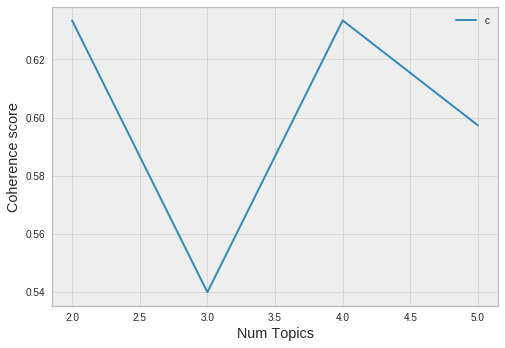

In [9]:
# coherence models: c_v, u_mass

def compute_coherence_values(dictionary, corpus, get_lda_model, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = get_lda_model(corpus, dictionary, num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append([num_topics, coherencemodel.get_coherence()])

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary, corpus, getLdaModel, word_vector_per_doc, limit=6, start=2, step=1)

coherence_values = np.array(coherence_values)
x = coherence_values.T[0]
y = coherence_values.T[1]

plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [10]:
SELECTED_TOPIC_AMOUNT = 5

lda_model = getLdaModel(corpus, dictionary, SELECTED_TOPIC_AMOUNT)
lda_model.print_topics(-1)

[(0,
  '0.009*"world" + 0.009*"cricket" + 0.009*"team" + 0.007*"play" + 0.007*"pakistan" + 0.007*"win" + 0.007*"year" + 0.007*"player" + 0.006*"time" + 0.006*"match"'),
 (1,
  '0.010*"price" + 0.008*"islamabad" + 0.007*"karachi" + 0.007*"r" + 0.005*"united" + 0.005*"peshawar" + 0.005*"mohammad" + 0.005*"litre" + 0.005*"win" + 0.005*"zalmi"'),
 (2,
  '0.016*"pakistan" + 0.010*"year" + 0.007*"minister" + 0.007*"country" + 0.007*"government" + 0.005*"tax" + 0.005*"economic" + 0.005*"company" + 0.005*"new" + 0.005*"project"'),
 (3,
  '0.015*"wicket" + 0.014*"test" + 0.012*"england" + 0.012*"ball" + 0.012*"run" + 0.010*"match" + 0.008*"captain" + 0.008*"pakistan" + 0.008*"sri" + 0.008*"win"'),
 (4,
  '0.022*"percent" + 0.016*"oil" + 0.013*"price" + 0.012*"market" + 0.009*"year" + 0.009*"us" + 0.008*"crude" + 0.008*"rise" + 0.007*"week" + 0.007*"fall"')]

# Display clusters using TSNE

In [11]:
def show_tsne_cluster(source):
    # hover tool
    hover = HoverTool(tooltips = [("Index","@idx"),("Category","@category"),("Title","@title")])

    colors = ["cyan","blue","purple","orange","brown","grey","black","yellow","green","pink","peru"]
    color_mapper = CategoricalColorMapper(factors=['0','1','2','3','4','5','6','7','8','9'], palette=colors)

    # plotting
    plot=figure(title ="TSNE Summaries",tools=[hover,"crosshair","pan","box_zoom","reset"])
    plot.circle("x","y", source=source, hover_color ="red", color=dict(field="topic", transform=color_mapper))

    show(plot,notebook_handle=True) 

In [12]:
def show_lda_tsne(lda_model, corpus):
    topic_weights = []

    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list])

    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)
    topic_str = []

    for n in topic_num:
        topic_str.append(str(n))

    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    source = ColumnDataSource(data={
        "x": tsne_lda[:,0],
        "y": tsne_lda[:,1],
        "title": docs_short,
        "topic": topic_str,
        "category": docs_category,
        "idx": np.arange(0,len(tsne_lda))
    })

    show_tsne_cluster(source)

show_lda_tsne(lda_model, corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2690 samples in 0.006s...
[t-SNE] Computed neighbors for 2690 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2690
[t-SNE] Computed conditional probabilities for sample 2000 / 2690
[t-SNE] Computed conditional probabilities for sample 2690 / 2690
[t-SNE] Mean sigma: 0.000100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.218685
[t-SNE] KL divergence after 1000 iterations: 0.290392


# Lets try doc2vec

In [13]:
enum_doc_vectors = [TaggedDocument(word_vector, [i]) for i, word_vector in enumerate(word_vector_per_doc)]
model = Doc2Vec(enum_doc_vectors, vector_size=10, window=2, min_count=4, workers=4)

doc2vec_results = [model.infer_vector(word_vector) for word_vector in word_vector_per_doc]

In [14]:
tsne_model = TSNE(n_components=2, verbose=1, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(doc2vec_results)

if not topic_str:
    topic_str = np.repeat('0', len(tsne_lda))

source = ColumnDataSource(data={
    "x": tsne_lda[:,0],
    "y": tsne_lda[:,1],
    "title": docs_short,
    "topic": topic_str,
    "category": docs_category,
    "idx": np.arange(0,len(tsne_lda))
})

show_tsne_cluster(source)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2692 samples in 0.002s...
[t-SNE] Computed neighbors for 2692 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2692
[t-SNE] Computed conditional probabilities for sample 2000 / 2692
[t-SNE] Computed conditional probabilities for sample 2692 / 2692
[t-SNE] Mean sigma: 0.284312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.916199
[t-SNE] KL divergence after 1000 iterations: 1.286744


NameError: name 'topic_str' is not defined

# Try to characterize new docs

In [15]:
print(model.infer_vector(["china", "stock"]))
model.wv.most_similar(positive=['stock'])

[-0.03213666 -0.04122762 -0.05076777 -0.01718856 -0.02419505 -0.00591326
  0.04670181 -0.03580813 -0.00136113 -0.07619122]


[('share', 0.9346784949302673),
 ('tokyo', 0.927166223526001),
 ('soarstrong', 0.924729585647583),
 ('currency', 0.9215240478515625),
 ('beneath', 0.906919002532959),
 ('pacific', 0.9020016193389893),
 ('asian', 0.8879150152206421),
 ('haven', 0.8863276839256287),
 ('investorstrong', 0.8860219120979309),
 ('shanghai', 0.8827205896377563)]

# Try to use KMean to group the clusters

In [16]:
NR_OF_CLUSTERS = 6

kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
kmeans.fit(tsne_lda)

print(kmeans.labels_[:10])

docs_short_arr = docs_short.array
docs_category_arr = docs_category.array

for clusterIdx in range(NR_OF_CLUSTERS):
    print("Main sentences in cluster", clusterIdx, ":")
    sentences = [(idx, docs_category_arr[idx], docs_short_arr[idx]) for idx, label in enumerate(kmeans.labels_) if label == clusterIdx]
    print(sentences[:5])
    print("")

[4 1 4 1 3 3 4 3 4 3]
Main sentences in cluster 0 :
[(33, 'business', 'pak imf talks conclude agreement for release of 518 milli'), (42, 'business', 'intra kashmir trade resumes after six day'), (45, 'business', 'nokia 215 dual sim launched in paki'), (46, 'business', 'cnic number now tax number only companies allowed ntn dar'), (71, 'business', 'bahria town kelectric ink agreement on power plants for karachi')]

Main sentences in cluster 1 :
[(1, 'business', 'asia stocks up in new year trad'), (3, 'business', 'asian stocks sink euro near nine year '), (10, 'business', 'tokyo stocks open 0.74 percent lower'), (17, 'business', 'asia stocks mostly higher ahead of ecb meeting'), (18, 'business', 'ecc approves export of 1.2 million tons of ')]

Main sentences in cluster 2 :
[(182, 'business', 'nisab i zakat deduction fixed at rs33641'), (629, 'business', 'Italy violin makers struggle profitab'), (1035, 'sports', 'Indian schoolboy breaches 1000 run mark in an inning'), (1038, 'sports', 'Day

# LDA Mallet

In [17]:
def run_bash_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    print("Output for", cmd, ":", output)  
    print("Error:", error)  

copy_command = "cp -rf /kaggle/input/mallet/mallet-2.0.8 /tmp"
make_cmd_executable = "chmod 777 /tmp/mallet-2.0.8/bin/mallet"

run_bash_command(copy_command)
run_bash_command(make_cmd_executable)

Output for cp -rf /kaggle/input/mallet/mallet-2.0.8 /tmp : b''
Error: None
Output for chmod 777 /tmp/mallet-2.0.8/bin/mallet : b''
Error: None


In [18]:
def get_lda_mallet_model(corpus, dictionary, nr_of_topics):
    mallet_path = '/tmp/mallet-2.0.8/bin/mallet'
    lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=nr_of_topics, id2word=dictionary)
    return lda_mallet
    
lda_mallet = get_lda_mallet_model(corpus, dictionary, 4)

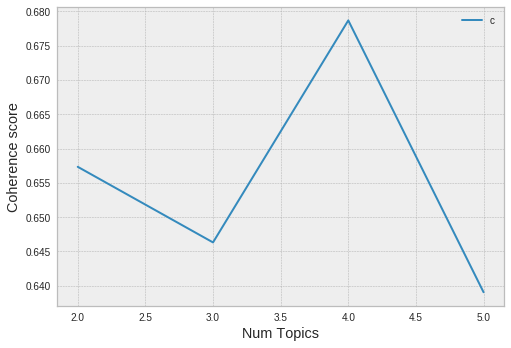

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, get_lda_mallet_model, word_vector_per_doc, limit=6, start=2, step=1)

coherence_values = np.array(coherence_values)
x = coherence_values.T[0]
y = coherence_values.T[1]

plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
show_lda_tsne(lda_mallet, corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2637 samples in 0.001s...
[t-SNE] Computed neighbors for 2637 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2637
[t-SNE] Computed conditional probabilities for sample 2000 / 2637
[t-SNE] Computed conditional probabilities for sample 2637 / 2637
[t-SNE] Mean sigma: 0.019652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.015182
[t-SNE] KL divergence after 1000 iterations: 0.638322
